In [ ]:
!pip3 install tldextract
!pip3 install pandas
!pip3 install scikit-learn
!pip3 install tldextract
!pip3 install matplotlib

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from urllib.parse import urlparse
import tldextract
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('dataset.csv')

# Extrair Atributos

In [3]:
#Função para criar os atributos que serão utilizados no modelo

def extract_features(url):

    parsed_url = urlparse(url)

    # Domain
    domain = parsed_url.netloc
    domain_length = len(domain)
    num_subdomains = domain.count('.')
    has_hyphen = '-' in domain

    # Path
    path = parsed_url.path
    path_length = len(path)
    num_path_segments = path.count('/')

    # Top-Level Domain (TLD)
    tld_info = tldextract.extract(domain)
    tld = tld_info.suffix
    tld_length = len(tld)
    subdomain = tld_info.subdomain

    # Protocol
    protocol = parsed_url.scheme
    is_https = protocol == 'https'

    # Query Parameters
    query_params = parsed_url.query
    num_query_params = len(query_params.split('&'))

    # URL Length
    url_length = len(url)

    # URL Structure
    has_redirect = '->' in url
    shortened_urls = ['bit.ly', 't.co', 'ow.ly']
    has_shortened_url = any(short_url in url for short_url in shortened_urls)

    feature_array = [
        domain_length, num_subdomains, int(has_hyphen),
        path_length, num_path_segments, tld_length,
        int(is_https), num_query_params, url_length,
        int(has_redirect), int(has_shortened_url)
    ]

    return feature_array

In [4]:
#Devido ao urlparser utilizar sitaxe da RFC1808 todas as URL precisam ter dois contra-barras (\\) mesmo que não tenho o protocolo antes.
#Caso não siga esse padrão o urlparser analisa errado.
def add_protocol(url):
    if '://' not in url:
        return '//' + url
    return url

In [5]:
#Matriz onde serão gravados os atributos.
dataWithFeatures = []

#Loop para extrair os atributos de cada URL
#Para algumas URLs o urlparser tentava interpretar como um IPv6 e retornava um erro, assim foi necesário o try/catch.
try:
  for index, row in dataset.iterrows():
      newRow = []
      url = row['url']
      label = row['class']

      url = add_protocol(url)

      features = extract_features(url)

      for feature in features:
          newRow.append(feature)

      newRow.append(label)

      dataWithFeatures.append(newRow)
except:
  pass

data = pd.DataFrame(dataWithFeatures)


In [6]:
data.head

<bound method NDFrame.head of         0   1   2   3   4   5   6   7    8   9   10         11
0       16   2   1   0   0   6   0   1   18   0   0  malicious
1       11   1   0  24   2   3   0   1   37   0   0     benign
2       14   1   0  17   3   3   0   1   33   0   0     benign
3       21   2   1  10   1   2   0   4   88   0   0  malicious
4       23   1   1  10   1   3   0   3  235   0   0  malicious
...     ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..        ...
573426  18   0   0   0   0   0   0   1   20   0   0  malicious
573427  44   0   0   0   0   0   0   1   46   0   0  malicious
573428  26   1   0  10   1   0   0   1   38   0   0  malicious
573429   9   1   0  13   2   3   0   2  218   0   0  malicious
573430  27   0   0   0   0   0   0   1   29   0   0  malicious

[573431 rows x 12 columns]>

# Normalização

In [7]:
#Mudança da label de texto para valor numérico, sendo 0 para benigno e 1 para maligno
encoder = LabelEncoder()

for i  in data.select_dtypes(include="object").columns.values:
    data[i]=encoder.fit_transform(data[i])

#Normalização dos valores
scaler = MinMaxScaler()

data = scaler.fit_transform(data)
data = pd.DataFrame(data)


In [8]:
data.head

<bound method NDFrame.head of               0         1    2         3         4         5    6     7   \
0       0.064516  0.074074  1.0  0.000000  0.000000  0.333333  0.0  0.00   
1       0.044355  0.037037  0.0  0.014286  0.051282  0.166667  0.0  0.00   
2       0.056452  0.037037  0.0  0.010119  0.076923  0.166667  0.0  0.00   
3       0.084677  0.074074  1.0  0.005952  0.025641  0.111111  0.0  0.06   
4       0.092742  0.037037  1.0  0.005952  0.025641  0.166667  0.0  0.04   
...          ...       ...  ...       ...       ...       ...  ...   ...   
573426  0.072581  0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.00   
573427  0.177419  0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.00   
573428  0.104839  0.037037  0.0  0.005952  0.025641  0.000000  0.0  0.00   
573429  0.036290  0.037037  0.0  0.007738  0.051282  0.166667  0.0  0.02   
573430  0.108871  0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.00   

              8    9    10   11  
0       0.005304  0.0  

# Divisão treino e teste

In [9]:
#Separação de atributos e label
x = data.iloc[:, 0:-1]
y = data.iloc[:, -1]

#Separação entre treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)


# KNN


Accuracy: 0.958

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     38028
         1.0       0.95      0.93      0.94     19316

    accuracy                           0.96     57344
   macro avg       0.96      0.95      0.95     57344
weighted avg       0.96      0.96      0.96     57344



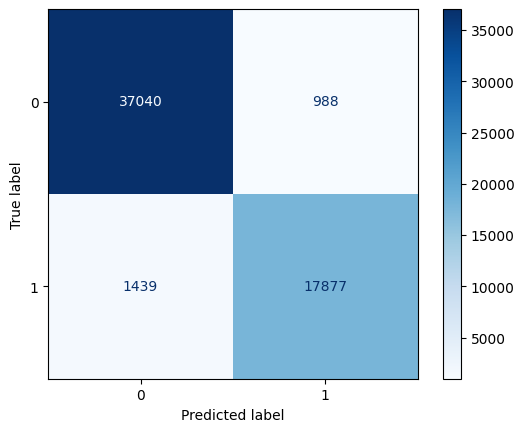

In [10]:
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)

knn_accuracy = accuracy_score(y_test, y_pred)
print(f'\nAccuracy: {knn_accuracy:.3f}\n')

class_report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{class_report}')

knn_conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(knn_conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


# Random Forest


Accuracy: 0.968

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98     38028
         1.0       0.96      0.94      0.95     19316

    accuracy                           0.97     57344
   macro avg       0.97      0.96      0.96     57344
weighted avg       0.97      0.97      0.97     57344



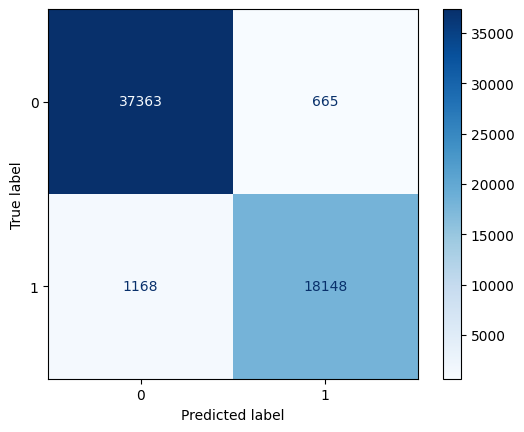

In [11]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

random_forest.fit(x_train, y_train)

y_pred = random_forest.predict(x_test)

rf_accuracy = accuracy_score(y_test, y_pred)
print(f'\nAccuracy: {rf_accuracy:.3f}\n')

class_report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{class_report}')

rf_conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(rf_conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Extra Trees Classifier


Accuracy: 0.968

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98     38028
         1.0       0.97      0.94      0.95     19316

    accuracy                           0.97     57344
   macro avg       0.97      0.96      0.96     57344
weighted avg       0.97      0.97      0.97     57344



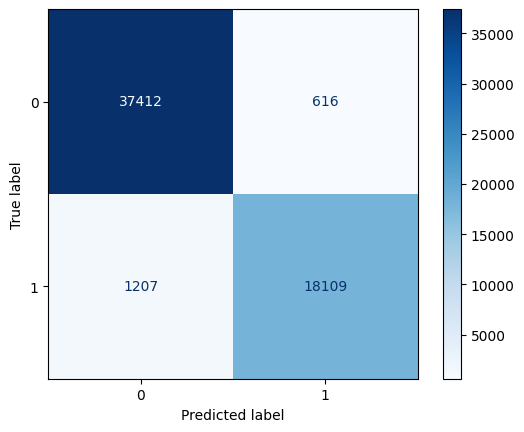

In [12]:
extra_trees = ExtraTreesClassifier(n_estimators=100, random_state=42)

extra_trees.fit(x_train, y_train)

y_pred = extra_trees.predict(x_test)

et_accuracy = accuracy_score(y_test, y_pred)
print(f'\nAccuracy: {et_accuracy:.3f}\n')

class_report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{class_report}')

et_conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(et_conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


# Gaussian Naive Bayes


Accuracy: 0.787

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.96      0.86     38028
         1.0       0.86      0.44      0.58     19316

    accuracy                           0.79     57344
   macro avg       0.82      0.70      0.72     57344
weighted avg       0.80      0.79      0.76     57344



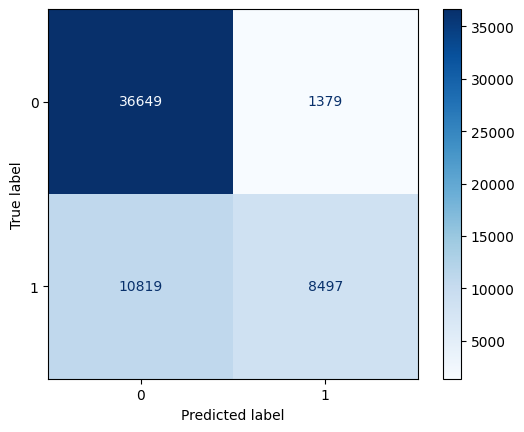

In [13]:
gnb = GaussianNB()

gnb.fit(x_train, y_train)

y_pred = gnb.predict(x_test)

gnb_accuracy = accuracy_score(y_test, y_pred)
print(f'\nAccuracy: {gnb_accuracy:.3f}\n')

class_report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{class_report}')

gnb_conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(gnb_conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


# Adaboost


Accuracy: 0.877

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     38028
         1.0       0.87      0.75      0.80     19316

    accuracy                           0.88     57344
   macro avg       0.87      0.84      0.86     57344
weighted avg       0.88      0.88      0.87     57344



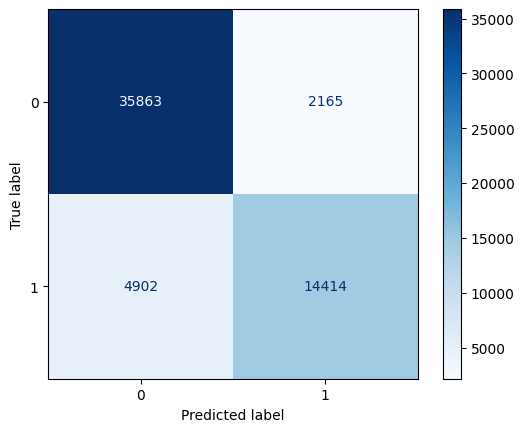

In [14]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)

adaboost.fit(x_train, y_train)

y_pred = adaboost.predict(x_test)

ab_accuracy = accuracy_score(y_test, y_pred)
print(f'\nAccuracy: {ab_accuracy:.3f}\n')

class_report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{class_report}')

ab_conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(ab_conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Gráfico comparação

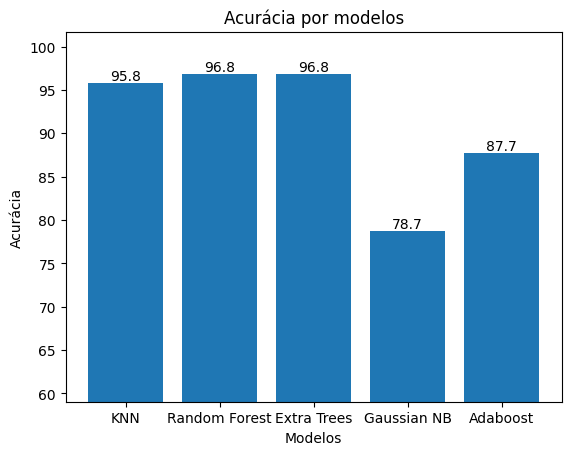

In [27]:
algorithm = ['KNN', 'Random Forest', 'Extra Trees', 'Gaussian NB', 'Adaboost']
accuracies = [knn_accuracy*100, rf_accuracy*100, et_accuracy*100, gnb_accuracy*100, ab_accuracy*100]
bars = plt.bar(algorithm, accuracies)
plt.xlabel('Modelos') 
plt.ylabel('Acurácia') 
plt.title('Acurácia por modelos')

plt.ylim(bottom=0.75 * min(accuracies))
for bar, valor in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(valor, 1),
             ha='center', va='bottom')

plt.show()